In [1]:
import os
import sys
import numpy as np

IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR)

from imatools.common import vtktools as vtku
from imatools.common import ioutils as iou

def calc_cog(pts, el):
    return [np.mean(pts[ee], 0) for ee in el]


def norm2(a): return np.linalg.norm(a)
def norm_vec(a): return a/norm2(a)


def remove_from_dirlist(dir_list, name_to_rm):
    if name_to_rm in dir_list:
        dir_list.remove(name_to_rm)

    return dir_list

def perc_above(arr, th) : 
    return np.sum(arr>th) / len(arr)

def perc_below(arr, th) : 
    return np.sum(arr<th) / len(arr)

In [2]:
import pandas as pd

# Locations of hard drive based on platform
dirdic = {'macOS': '/Volumes/sandisk',
          'Linux': '/media/jsl19/sandisk',
          'Windows': 'D:/'}

tex_dic = {'macOS': '/Users/jsolislemus/Documents/TEX',
           'Linux': '/home/jsl19/Documents/tex'}

base_dir = iou.fullfile(dirdic[iou.chooseplatform()], '01_atrialfibres/06_Reproducibility/05_UserProjects')
comp_dir = iou.fullfile(base_dir, '011_comparisons')

ld = remove_from_dirlist(os.listdir(iou.fullfile(comp_dir,'C0')), 'COMPARISONS')
ld = remove_from_dirlist(ld, 'MAPPING')

CX = ['C' + str(n) for n in np.linspace(0,49,num=50, dtype=int)]

print(ld)

['M1', 'M2']


# Comparisons
Array of `inter/intra`

Array of `auto/manual/mixed`

In [17]:
df_comp = pd.read_csv(iou.fullfile(comp_dir, 'comparisons_path.csv'))
mode = df_comp['mode']
mode = mode[np.linspace(0,98,num=50, dtype=int)]

processing_raw = df_comp['processing'].tolist()
processing_raw = [processing_raw[ix] + processing_raw[ix+1] for ix in range(50)]

a='automatic'
m='manual'

processing = [p.replace(a+a, a) for p in processing_raw]
processing = [p.replace(m+m, m) for p in processing]
processing = [p.replace(a+m, 'mixed') for p in processing]
processing = [p.replace(m+a, 'mixed') for p in processing]

In [31]:
import scipy
def total_activation_time(lat) : 
    return np.max(lat)-np.min(lat)

def mean_conduction_velocity(gradlat) : 
    return np.mean(1/gradlat)

comparison_list = [c.replace('/Volumes', '/media/jsl19') for c in df_comp['comparison_path'].tolist()]
cx = 0 # go in even numbers! 

comp_a = comparison_list[cx]
comp_b = comparison_list[cx+1]

fun = {
    'lat' : total_activation_time,
    'gradlat' : mean_conduction_velocity
}

files_and_mapping = {
    'lat' : ('LAT_RSPV_X.dat', 'fibre_X_pts.csv'), 
    'gradlat': ('lat_X.gradmag.dat', 'fibre_X_pts.csv'), 
    'ps' : ('PSNodeSmooth.dat', 'input_pts.csv'), 
    'f_endo' : ('fibre_X_endo.lon', 'fibre_X_endo_elem.csv'),
    'f_epi' : ('fibre_X_epi.lon', 'fibre_X_epi_elem.csv')
}

dx = 'gradlat'
mx = 'l'

fname = files_and_mapping[dx][0].replace('X', mx)
mname = files_and_mapping[dx][1].replace('X', mx)

f_a = np.loadtxt(iou.fullfile(comp_a, fname))
f_b = np.loadtxt(iou.fullfile(comp_b, fname))
# fun[dx](f_a) - fun[dx](f_b)
tst = scipy.stats.ks_2samp(1/f_a, 1/f_b,alternative='two-sided')

tst.pvalue

0.0

In [39]:
import seaborn as sns

debug = False

CX = ['C' + str(n) for n in np.linspace(0,49,num=50, dtype=int)]
FVX = ['f_endo', 
    'f_epi']
FSX = ['gradlat',
    'lat',
    'ps']

files_dic = {
    'scalar' : FSX, 
    'vector' : FVX
}

var_dic = {
    'scalar' : 'diff_abs', 
    'vector' : 'abs_dot_product'
}

fibres_list = ['1', 'l']

field = 'scalar'

print(field)

odic = dict()
endo_fibres = np.empty((1,1))
epi_fibres = np.empty((1,1))
for fx in range(len(files_dic[field])) : 
    mean_var = np.zeros(50, dtype=float)
    std_var  = np.zeros(50, dtype=float)
    prc75_var = np.zeros(50, dtype=float)
    corr_var = np.zeros(50, dtype=float)

    for fibre in fibres_list : 
        file_name = files_dic[field][fx] + '_' + fibre 

        for cx in range(len(CX)) :  
            test_path = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', file_name + '.csv') 
            df = pd.read_csv(test_path, index_col=False)

            if field == 'scalar' : 
                mean_var[cx] = np.mean(df[var_dic[field]])
                std_var[cx]  = np.std(df[var_dic[field]]) 
                prc75_var[cx]  = np.percentile(df[var_dic[field]], 75) 
                if files_dic[field][fx] == 'ps' : 
                    CORR_MAT = np.corrcoef(df['ps_0'], df['ps_1'])
                    corr_var[cx]  =  CORR_MAT[0,1]
            else : # field == 'vector
                if 'endo' in file_name : 
                    endo_fibres = np.concatenate((endo_fibres, df[var_dic[field]]))
                else :
                    epi_fibres = np.concatenate((epi_fibres, df[var_dic[field]]))

        
        if field == 'scalar' : 
            odic[files_dic[field][fx] + '_mean'] = mean_var
            odic[files_dic[field][fx] + '_std'] = std_var
            odic[files_dic[field][fx] + '_prc75'] = prc75_var
            if files_dic[field][fx] == 'ps':
                odic[files_dic[field][fx] + '_corr2'] = corr_var
    
odic['mode'] = mode
odic['processing'] = processing

o_df_inter_intra = pd.DataFrame(odic)

scalar


/Users/jsolislemus/anaconda3/anaconda3/envs/imatools/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jsolislemus/anaconda3/anaconda3/envs/imatools/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/jsolislemus/anaconda3/anaconda3/envs/imatools/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jsolislemus/anaconda3/anaconda3/envs/imatools/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [17]:
import seaborn as sns

debug = False

CX = ['C' + str(n) for n in np.linspace(0, 49, num=50, dtype=int)]
FVX = ['f_endo',
       'f_epi']
FSX = ['gradlat',
       'lat',
       'ps']

files_dic = {
    'scalar': FSX,
    'vector': FVX
}

var_dic = {
    'scalar': 'diff_abs',
    'vector': 'abs_dot_product'
}

fibres_list = ['1', 'l']

field_list = ['scalar', 'vector']

field = 'vector'

for fx in range(len(files_dic[field])):
    for fibre in fibres_list:
        file_name = files_dic[field][fx] + '_' + fibre
        print(file_name)
        for cx in range(len(CX)):
            num = 1 if cx==0 or cx==30 else 2
            comp_type = 'inter' if cx<30 else 'intra'
            
            test_path = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', file_name + '.csv')
            opath = iou.fullfile(comp_dir, 'fibres_comp_'+files_dic[field][fx][2:] + '_' + fibre + '_' + comp_type+'.csv')
            os.system('tail --lines=+{} {} | awk -F\',\'  \'{{print $1\",\"$4}}\' >> {}'.format(num, test_path, opath))



f_endo_1
f_endo_l
f_epi_1
f_epi_l


In [40]:
def compare_atlas_differences(pa_1, pa_l, pb_1, pb_l, reciprocal=False) : 
    a_1 = np.loadtxt(pa_1)
    a_l = np.loadtxt(pa_l)
    b_1 = np.loadtxt(pb_1)
    b_l = np.loadtxt(pb_l)

    if reciprocal :     
        meas_1 = 1 / np.concatenate((a_1, b_1))
        meas_l = 1 / np.concatenate((a_l, b_l))
    else : 
        meas_1 = np.concatenate((a_1, b_1))
        meas_l = np.concatenate((a_l, b_l))
    
    compy = np.abs(meas_1-meas_l)
    
    mean_var = np.mean(compy)
    std_var = np.std(compy)
    prc75_var = np.percentile(compy, 75)
    
    return mean_var, std_var, prc75_var


myl = ['LAT_RSPV_X.dat', 
    'lat_X.gradmag.dat']

FSX = ['gradlat',
    'lat']

'gradmag' in myl[1]
odic = dict()
mode_bis = ['atlas'] * 50

for ix in range(len(myl)) : 

    mean_var = np.zeros(50, dtype=float)
    std_var = np.zeros(50, dtype=float)
    prc75_var = np.zeros(50, dtype=float)
    for cx in range(len(CX)) : 
        m = ['M'+str(2*cx+1), 'M'+str(2*cx+2)]

        pathA_1 = iou.fullfile(comp_dir, CX[cx], m[0], myl[ix].replace('X', '1'))
        pathA_l = iou.fullfile(comp_dir, CX[cx], m[0], myl[ix].replace('X', 'l'))
        pathB_1 = iou.fullfile(comp_dir, CX[cx], m[1], myl[ix].replace('X', '1'))
        pathB_l = iou.fullfile(comp_dir, CX[cx], m[1], myl[ix].replace('X', 'l'))

        mv, stv, p75 = compare_atlas_differences(pathA_1, pathA_l, pathB_1, pathB_l, ('gradmag' in myl[ix]))
        
        mean_var[cx] = mv
        std_var[cx] = stv
        prc75_var[cx] = p75
    
    odic[FSX[ix] + '_mean'] = mean_var
    odic[FSX[ix] + '_std'] = std_var
    odic[FSX[ix] + '_prc75'] = prc75_var

odic['mode'] = mode_bis
odic['processing'] = processing

o_df_atlas = pd.DataFrame(odic)

/var/folders/4g/sz_zl6x1255fc86zws80bsbh0000gn/T/ipykernel_13489/2914668221.py:8: RuntimeWarning: divide by zero encountered in true_divide
  meas_1 = 1 / np.concatenate((a_1, b_1))
/Users/jsolislemus/anaconda3/anaconda3/envs/imatools/lib/python3.8/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [33]:
mode_bis = ['atlas'] * 50

odic['mode'] = mode_bis
odic['processing'] = processing

o_df_atlas = pd.DataFrame(odic)

o_df_atlas.median()

# o_df = pd.concat([o_df_inter_intra, o_df_atlas])
# o_df.to_csv(iou.fullfile(comp_dir, 'measurements.csv'))

/var/folders/4g/sz_zl6x1255fc86zws80bsbh0000gn/T/ipykernel_18855/1663174770.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  o_df_atlas.median()


gradlat_mean      11.817771
gradlat_std        7.669366
gradlat_prc75     17.934013
lat_mean         202.911933
lat_std          267.256638
lat_prc75        285.011526
dtype: float64

In [44]:
odf = pd.concat([o_df_inter_intra, o_df_atlas])



,gradlat_mean,gradlat_std,gradlat_prc75,lat_mean,lat_std,lat_prc75,ps_mean,ps_std,ps_prc75,ps_corr2,mode,processing
0,246.433830,311.178283,349.436695,10.341166,7.353976,14.917000,0.069957,0.185248,0.045761,0.020221,inter,mixed
2,80.754831,230.880411,90.487169,3.212442,1.703581,4.925900,0.015075,0.059736,0.002283,0.318511,inter,automatic
4,63.791317,233.479807,52.738436,2.994254,0.951629,3.411000,0.004460,0.018005,0.000195,0.507592,inter,automatic
6,167.435703,346.474851,218.319851,12.968331,6.170732,16.963600,0.048219,0.166473,0.027792,-0.004568,inter,automatic
8,176.261259,324.561586,236.467205,7.378815,4.405439,10.518725,0.034644,0.071689,0.038911,0.083253,inter,automatic
...,...,...,...,...,...,...,...,...,...,...,...,...
45,14.371918,9.130584,21.311000,201.669478,268.909776,280.996384,NaN,NaN,NaN,NaN,atlas,mixed
46,11.150464,6.317262,15.708700,204.719258,317.793756,284.826427,NaN,NaN,NaN,NaN,atlas,automatic
47,14.947234,9.981242,22.725000,205.828992,246.956476,294.003833,NaN,NaN,NaN,NaN,atlas,automatic
48,10.837050,6.132233,15.324000,197.269467,266.124288,272.467368,NaN,NaN,NaN,NaN,atlas,automatic


In [51]:
# ddi = {
#     'local_cv' : o_df_inter_intra['gradlat_mean']/np.mean(o_df_inter_intra['gradlat_mean']),
#     'lat' : o_df_inter_intra['lat_mean']/np.mean(o_df_inter_intra['lat_mean']),
#     'mode' : o_df_inter_intra['mode'], 
#     'processing' : o_df_inter_intra['processing']
#     }

# pd.DataFrame(ddi)

o_df_inter_intra.median()

/var/folders/4g/sz_zl6x1255fc86zws80bsbh0000gn/T/ipykernel_13489/1066700515.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  o_df_inter_intra.median()


gradlat_mean     124.422665
gradlat_std      270.194254
gradlat_prc75    154.576061
lat_mean           4.183547
lat_std            2.554298
lat_prc75          6.099500
ps_mean            0.029662
ps_std             0.092428
ps_prc75           0.009825
ps_corr2           0.223463
dtype: float64

In [42]:
import scipy 

df_mixed = o_df_inter_intra[o_df_inter_intra['processing']=='mixed']
df_automatic = o_df_inter_intra[o_df_inter_intra['processing']=='automatic']
df_manual = o_df_inter_intra[o_df_inter_intra['processing']=='manual']

measure = ['gradlat_mean', 'ps_corr2']
m = measure[1]
print(m)

inter_mixed = df_mixed[m][df_mixed['mode']=='inter'] 
intra_mixed = df_mixed[m][df_mixed['mode']=='intra'] 
inter_automatic = df_automatic[m][df_automatic['mode']=='inter'] 
intra_automatic = df_automatic[m][df_automatic['mode']=='intra'] 
inter_manual = df_manual[m][df_manual['mode']=='inter'] 
intra_manual = df_manual[m][df_manual['mode']=='intra'] 

print(scipy.stats.ranksums(inter_mixed, intra_mixed, nan_policy='omit'))
print(scipy.stats.ranksums(inter_automatic, intra_automatic, nan_policy='omit'))
print(scipy.stats.ranksums(inter_manual, intra_manual, nan_policy='omit'))

ps_corr2
RanksumsResult(statistic=0.6793662204867574, pvalue=0.49690584756476797)
RanksumsResult(statistic=0.28867513459481287, pvalue=0.7728299926844475)
RanksumsResult(statistic=-0.07715167498104596, pvalue=0.9385028847784713)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


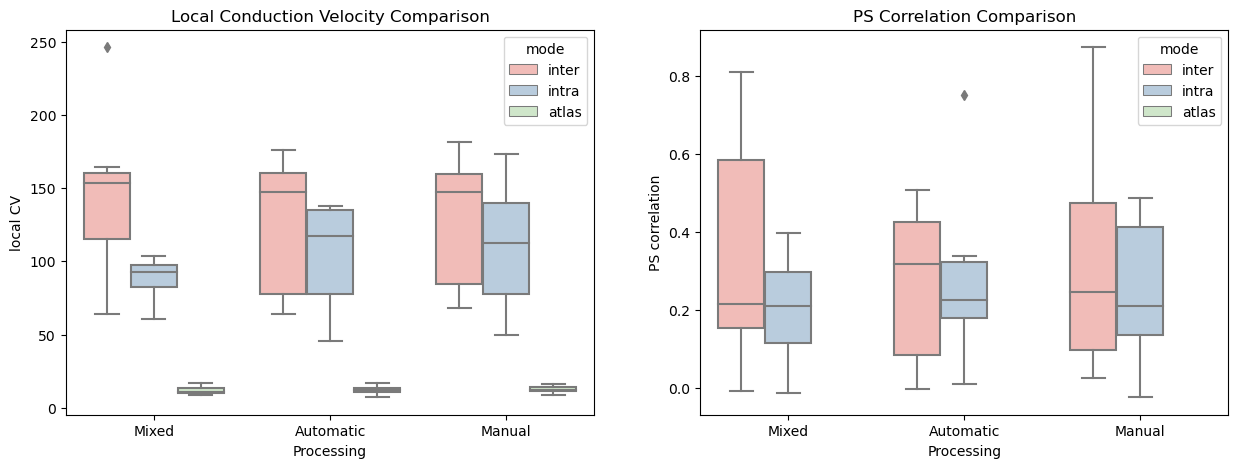

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

#  o_df = pd.read_csv(iou.fullfile(comp_dir, 'measurements.csv'), index_col=False)

fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax[0],  data=odf, x='processing', y='gradlat_mean', hue='mode')
sns.boxplot(ax=ax[1],  data=odf, x='processing', y='ps_corr2', hue='mode')

ax[0].set_xlabel('Processing')
ax[1].set_xlabel('Processing')
ax[0].set_xticklabels(['Mixed', 'Automatic', 'Manual'])
ax[1].set_xticklabels(['Mixed', 'Automatic', 'Manual'])
ax[0].set_ylabel('local CV')
ax[1].set_ylabel('PS correlation')
ax[0].set_title('Local Conduction Velocity Comparison')
ax[1].set_title('PS Correlation Comparison')

plt.savefig(iou.fullfile(comp_dir, 'sim_res.eps'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


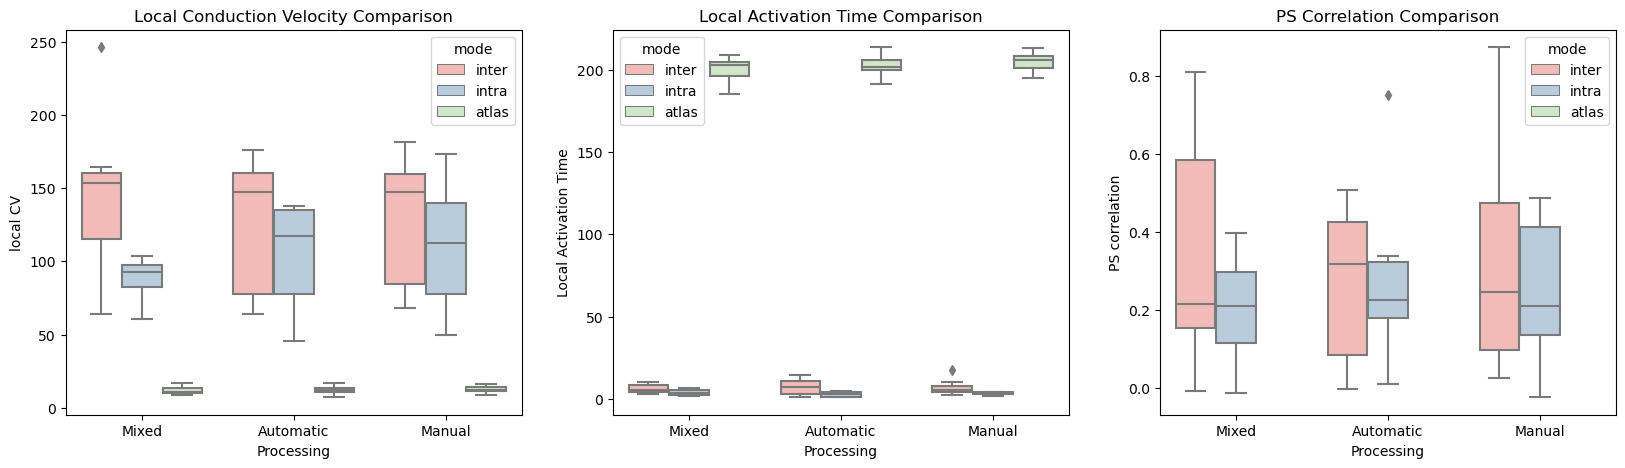

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

#  o_df = pd.read_csv(iou.fullfile(comp_dir, 'measurements.csv'), index_col=False)

fig, ax = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax[0],  data=odf, x='processing', y='gradlat_mean', hue='mode')
sns.boxplot(ax=ax[1],  data=odf, x='processing', y='lat_mean', hue='mode')
sns.boxplot(ax=ax[2],  data=odf, x='processing', y='ps_corr2', hue='mode')

ax[0].set_xlabel('Processing')
ax[0].set_xticklabels(['Mixed', 'Automatic', 'Manual'])
ax[0].set_ylabel('local CV')
ax[0].set_title('Local Conduction Velocity Comparison')
ax[1].set_xlabel('Processing')
ax[1].set_xticklabels(['Mixed', 'Automatic', 'Manual'])
ax[1].set_ylabel('Local Activation Time')
ax[1].set_title('Local Activation Time Comparison')
ax[2].set_xlabel('Processing')
ax[2].set_xticklabels(['Mixed', 'Automatic', 'Manual'])
ax[2].set_ylabel('PS correlation')
ax[2].set_title('PS Correlation Comparison')

plt.savefig(iou.fullfile(comp_dir, 'sim_res_with_lat.eps'))

In [3]:
import random 
n = 13652470  # number of records in filefibre
fibre
s = 1000000  # desired sample size
skipr = lambda nn,ss : sorted(random.sample(range(nn), nn-ss))

fraction_sample = 0.1
# compare fibres 
df_1_endo = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_endo_1.csv')).assign(fibre='1').assign(layer='endo').sample(frac=fraction_sample)
df_l_endo = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_endo_l.csv')).assign(fibre='l').assign(layer='endo').sample(frac=fraction_sample)
df_1_epi = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_epi_1.csv')).assign(fibre='1').assign(layer='epi').sample(frac=fraction_sample)
df_l_epi = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_epi_l.csv')).assign(fibre='l').assign(layer='epi').sample(frac=fraction_sample)



In [4]:
fraction_sample = 0.1
# compare fibres 

df_1_endo_inter = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_endo_1_inter.csv')).assign(fibre='1', layer='endo', comp='inter').sample(frac=fraction_sample)
df_l_endo_inter = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_endo_l_inter.csv')).assign(fibre='l', layer='endo', comp='inter').sample(frac=fraction_sample)
df_1_epi_inter = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_epi_1_inter.csv')).assign(fibre='1', layer='epi', comp='inter').sample(frac=fraction_sample)
df_l_epi_inter = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_epi_l_inter.csv')).assign(fibre='l', layer='epi', comp='inter').sample(frac=fraction_sample)

df_1_endo_intra = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_endo_1_intra.csv')).assign(fibre='1', layer='endo', comp='intra').sample(frac=fraction_sample)
df_l_endo_intra = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_endo_l_intra.csv')).assign(fibre='l', layer='endo', comp='intra').sample(frac=fraction_sample)
df_1_epi_intra = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_epi_1_intra.csv')).assign(fibre='1', layer='epi', comp='intra').sample(frac=fraction_sample)
df_l_epi_intra = pd.read_csv(iou.fullfile(comp_dir, 'fibres_comp_epi_l_intra.csv')).assign(fibre='l', layer='epi', comp='intra').sample(frac=fraction_sample)

DF_inter = pd.concat([df_1_endo_inter,df_l_endo_inter,df_1_epi_inter,df_l_epi_inter]).reset_index()
DF_intra = pd.concat([df_1_endo_intra,df_l_endo_intra,df_1_epi_intra,df_l_epi_intra]).reset_index()



In [13]:
DF_intra
# np.cos(np.deg2rad(40))

,index,region,abs_dot_product,fibre,layer,comp
0,5347811,21,0.964210,1,endo,intra
1,2573541,25,0.839450,1,endo,intra
2,1373132,11,0.574285,1,endo,intra
3,4707014,11,0.801349,1,endo,intra
4,667865,11,0.540116,1,endo,intra
...,...,...,...,...,...,...
2245855,2739211,12,0.999721,l,epi,intra
2245856,3495589,12,0.995258,l,epi,intra
2245857,3245039,12,0.999511,l,epi,intra
2245858,2851622,12,0.987001,l,epi,intra


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


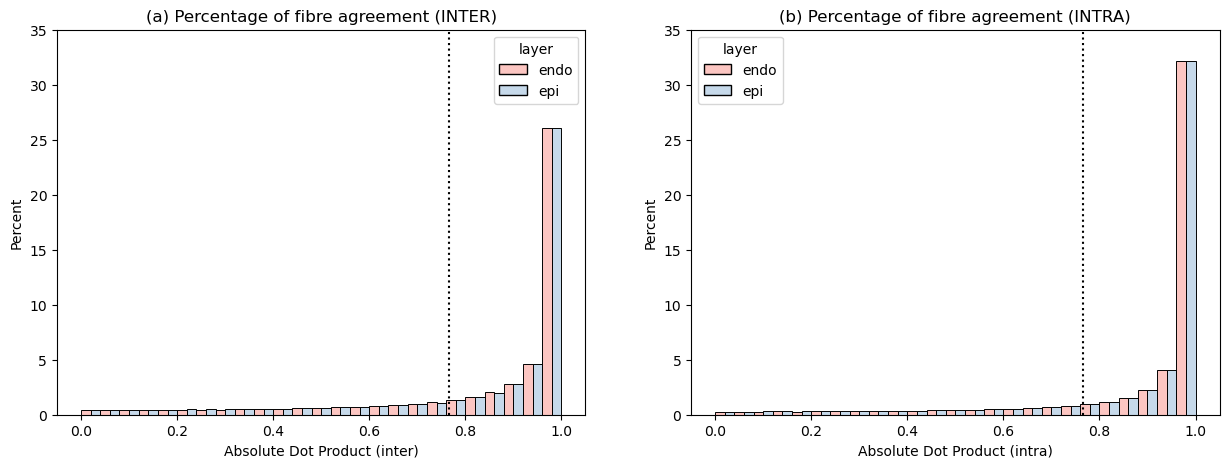

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

theta=40
xc=np.cos(np.deg2rad(theta))

fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
ax[0].axvline(x=xc, linestyle=':', color='k')
sns.histplot(ax=ax[0], data=DF_inter, x='abs_dot_product', hue='layer', bins=25, stat='percent', multiple='dodge')
ax[1].axvline(x=xc, linestyle=':', color='k')
sns.histplot(ax=ax[1], data=DF_intra, x='abs_dot_product', hue='layer', bins=25, stat='percent', multiple='dodge')

ax[0].set_ylim(bottom=0, top=35)
ax[1].set_ylim(bottom=0, top=35)
ax[0].set_xlabel('Absolute Dot Product (inter)')
ax[1].set_xlabel('Absolute Dot Product (intra)')
ax[0].set_title('(a) Percentage of fibre agreement (INTER)')
ax[1].set_title('(b) Percentage of fibre agreement (INTRA)')

plt.savefig(iou.fullfile(comp_dir, 'fibres_comp.eps'))


In [11]:

th=np.cos(np.deg2rad(40))
print('THRES: {}'.format(th))
print('INTER: {}'.format(np.sum(DF_inter['abs_dot_product']>th)/len(DF_inter)))
print('INTRA: {}'.format(np.sum(DF_intra['abs_dot_product']>th)/len(DF_intra)))

THRES: 0.766044443118978
INTER: 0.7647112430997309
INTRA: 0.8406944333128512


In [60]:

DF_endo = pd.concat([df_1_endo, df_l_endo]).reset_index()
DF_epi = pd.concat([df_1_epi, df_l_epi]).reset_index()
# 
# DF = pd.concat([df_1_endo, df_l_endo, df_1_epi, df_l_epi]).reset_index()

print(len(DF_endo))
print(len(DF_epi))


2730496
2730456


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


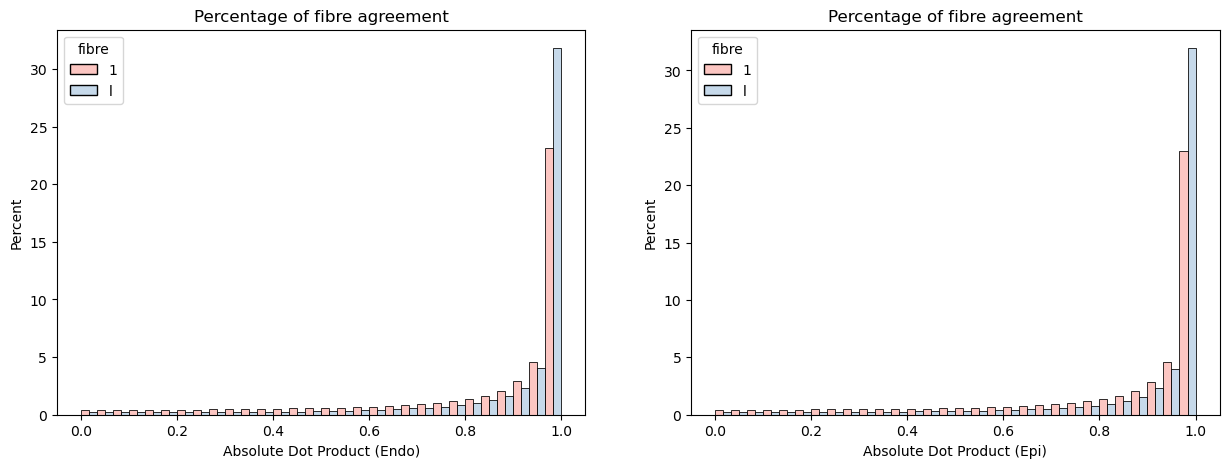

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.histplot(ax=ax[0], data=DF_endo, x='abs_dot_product', hue='fibre', bins=30, stat='percent', multiple='dodge')
sns.histplot(ax=ax[1], data=DF_epi, x='abs_dot_product', hue='fibre', bins=30, stat='percent', multiple='dodge')

ax[0].set_xlabel('Absolute Dot Product (Endo)')
ax[1].set_xlabel('Absolute Dot Product (Epi)')
ax[0].set_title('Percentage of fibre agreement')
ax[1].set_title('Percentage of fibre agreement')

plt.savefig(iou.fullfile(comp_dir, 'fibres_comp.eps'))

In [4]:
DF = pd.concat([df_1_endo, df_l_endo, df_1_epi, df_l_epi]).reset_index()


In [11]:
th = 0.86

print(np.rad2deg(np.arccos(th)))
print(np.sum(DF['abs_dot_product']>th)/len(DF))

0.7305738999353959

30.68341710897582